In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

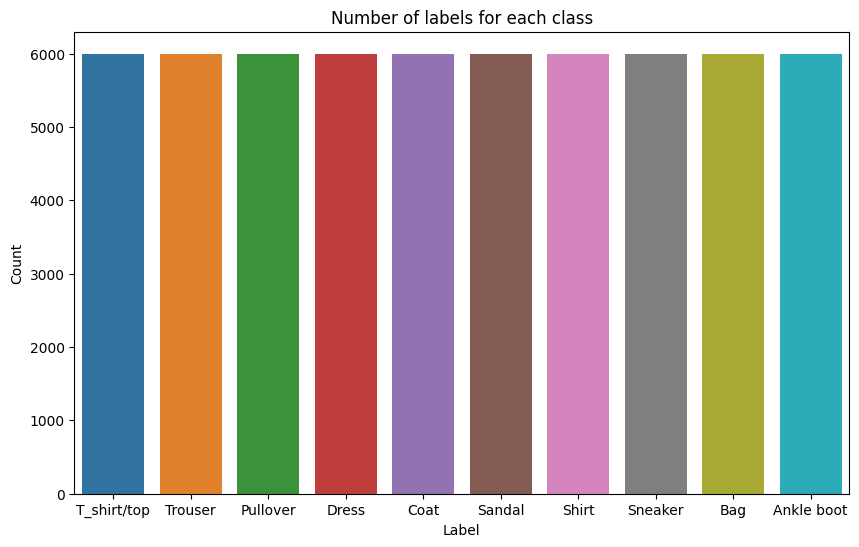

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_train)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Number of labels for each class")
plt.xticks(ticks=range(10), labels=class_names)
plt.show()

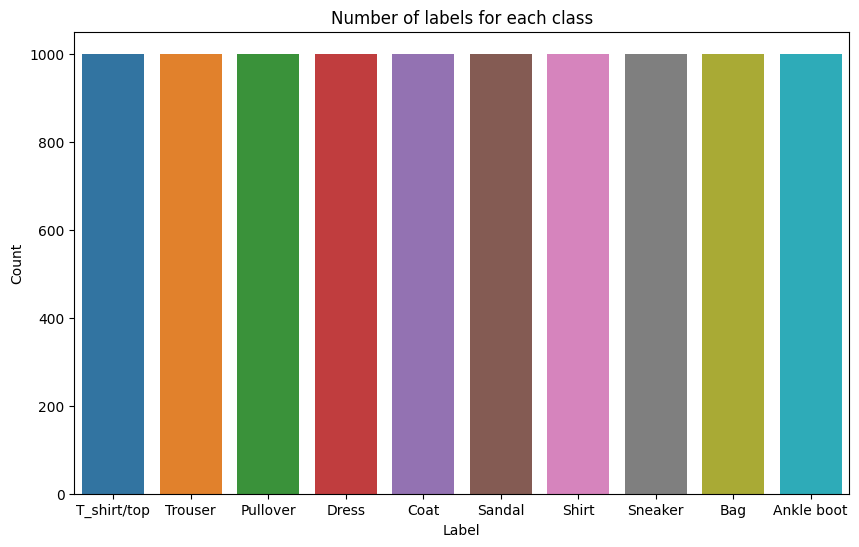

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_test)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Number of labels for each class")
plt.xticks(ticks=range(10), labels=class_names)
plt.show()

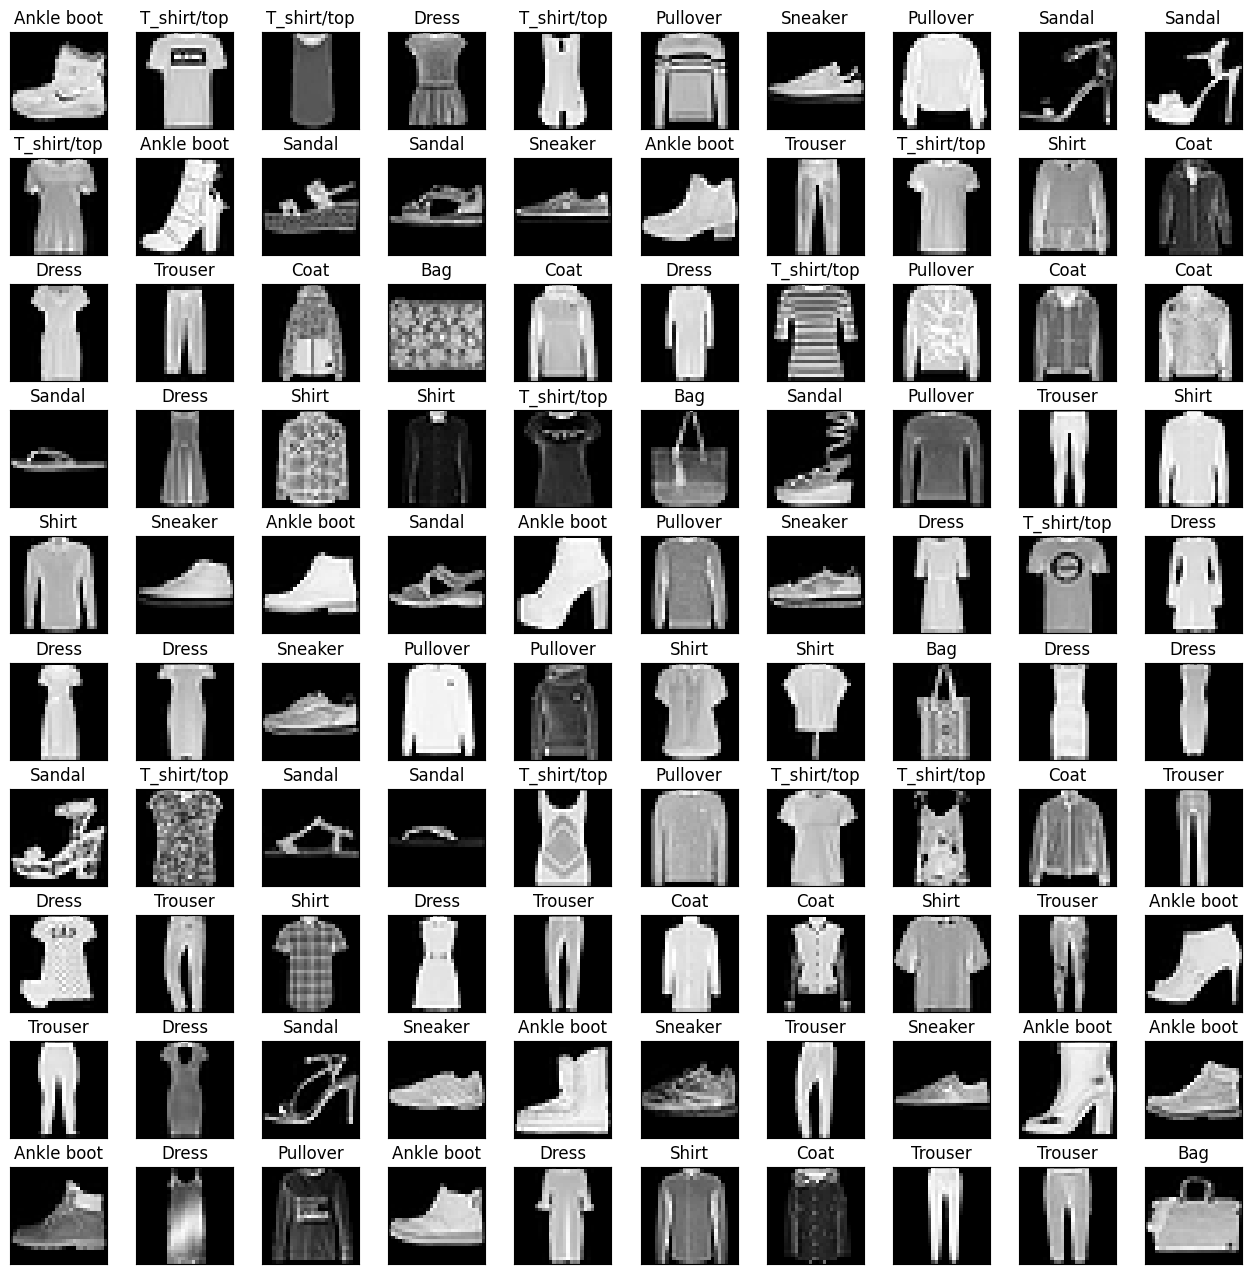

In [9]:
plt.figure(figsize=(16, 16))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)), cmap = "gray")
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
    plt.subplots_adjust(hspace=0.3)
plt.show()

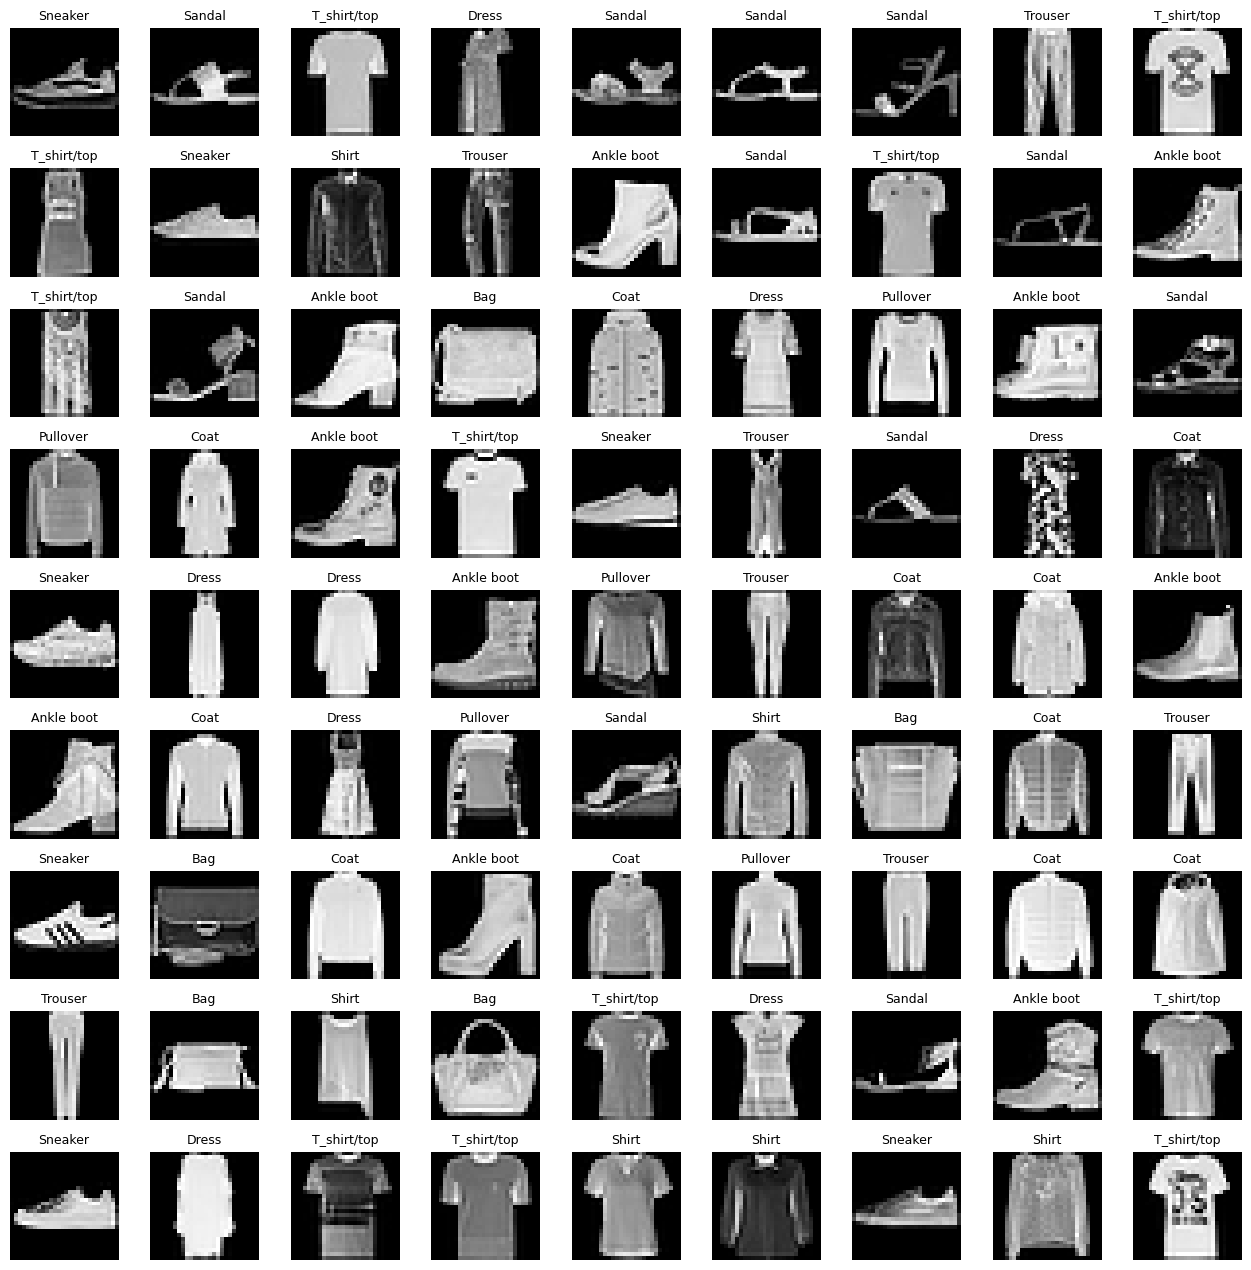

In [10]:
W_grid = 9
L_grid = 9

fig, axes = plt.subplots(L_grid, W_grid, figsize=(16, 16))
axes = axes.ravel()
n_train = len(x_train)

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(x_train[index].reshape((28, 28)), cmap='gray')
    labelindex = int(y_train[index])
    axes[i].set_title(class_names[labelindex], fontsize=9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.show()

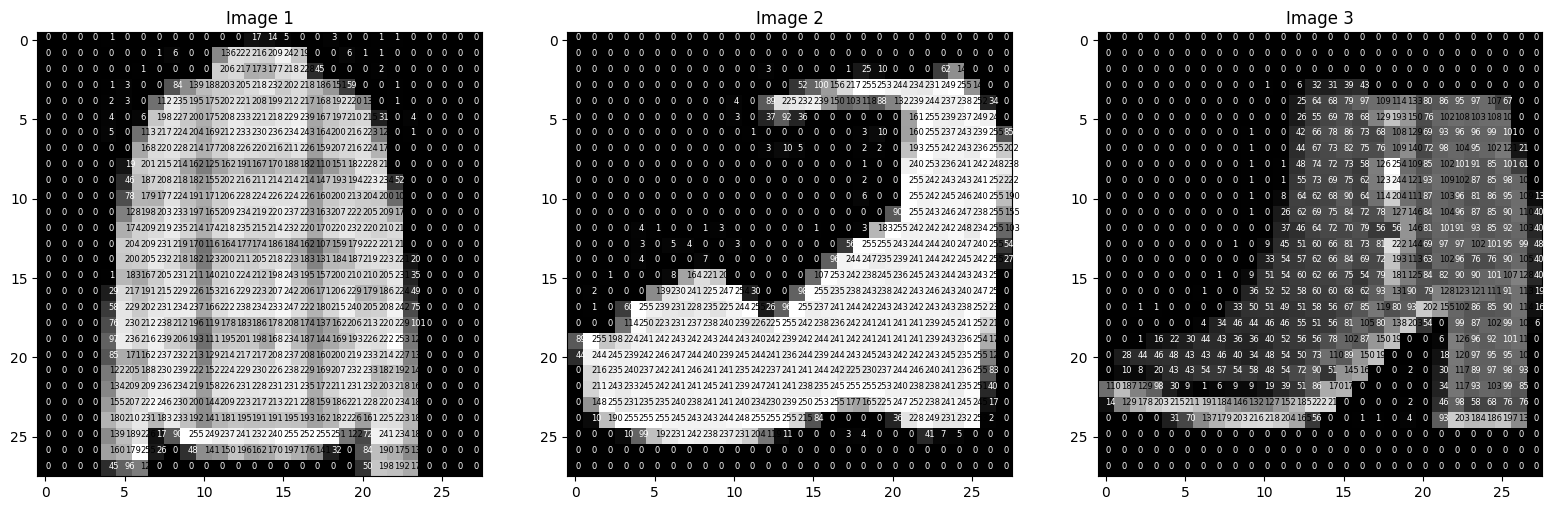

In [11]:
def pixel_visualize_multiple(images, num_images=3):
    if isinstance(images, np.ndarray):
        random_indices = np.random.choice(images.shape[0], num_images, replace=False)
        selected_images = images[random_indices]
    else:
        selected_images = images[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(16, 5))
    
    for i, img in enumerate(selected_images):
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f'Image {i+1}')
        
        width, height = img.shape
        threshold = img.max()/2.5
        
        for x in range(width):
            for y in range(height):
                axes[i].annotate(str(round(img[x][y], 2)), 
                                 xy=(y,x), 
                                 color='white' if img[x][y] < threshold else 'black',
                                 fontsize=6)
    
    plt.tight_layout()
    plt.show()

pixel_visualize_multiple(x_train)

In [12]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [13]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [14]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [15]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [16]:
input_dim = x_train.shape[1]
encoding_dim = 64

In [17]:
input_dim

784

In [18]:
input_image = Input(shape = (input_dim,))
encoded = Dense(256, activation = "relu")(input_image)
encoded = Dense(128, activation = "relu")(encoded)
encoded = Dense(encoding_dim, activation = "relu")(encoded)

2025-04-19 19:00:15.693211: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
decoded = Dense(128, activation = "relu")(encoded)
decoded = Dense(256, activation = "relu")(decoded)
decoded = Dense(input_dim, activation = "sigmoid")(decoded)

In [20]:
autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer = Adam(), loss = "binary_crossentropy")

In [21]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 484,944 (1.85 MB)

 Trainable params: 484,944 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = autoencoder.fit(x_train, x_train, epochs = 50,
                          batch_size = 64, shuffle = True,
                          validation_data = (x_test, x_test),
                          verbose = 1)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3580 - val_loss: 0.2926
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2882 - val_loss: 0.2851
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2806 - val_loss: 0.2807
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.2775 - val_loss: 0.2781
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2751 - val_loss: 0.2760
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2726 - val_loss: 0.2742
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2720 - val_loss: 0.2732
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.2707 - val_loss: 0.2724
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2692 - val_loss: 0.2718
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2693 - val_loss: 0.2709
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2680 - val_loss: 0.2701
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/ste

In [23]:
encoder = Model(input_image, encoded)

In [24]:
encoded_input = Input(shape = (encoding_dim,))
decoder_layer1 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_output = autoencoder.layers[-1](decoder_layer2)

decoder = Model(encoded_input, decoder_output)

In [25]:
encoded_images = encoder.predict(x_test)
decoded_images = decoder.predict(encoded_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


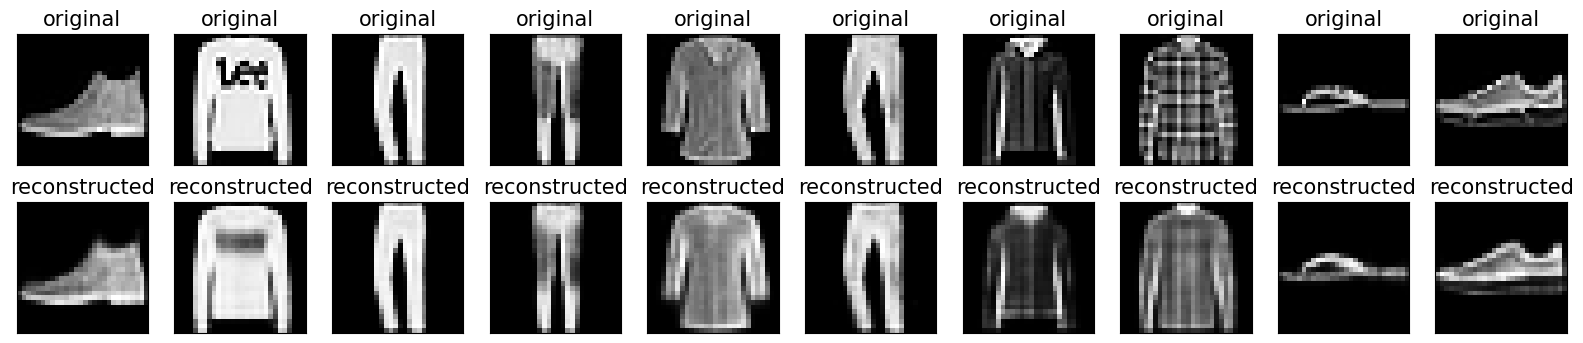

In [26]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap = "gray")
    plt.title("original",fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap = "gray")
    plt.title("reconstructed",fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [27]:
def compute_ssim(original, reconstructed):
    original = original.reshape(28, 28)
    reconstructed = reconstructed.reshape(28, 28)
    return ssim(original, reconstructed, data_range=1)


ssim_score = []

In [28]:
for i in range(100):
    original_img = x_test[i]
    reconstructed_img = decoded_images[i]
    score = compute_ssim(original_img, reconstructed_img)
    ssim_score.append(score)

In [29]:
average_ssim = np.mean(ssim_score)
print("SSIM: ", average_ssim)

SSIM:  0.8352727444634762
